# Parte II - Classificação binária com redes MLP e SVMs

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.io as sio

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

%matplotlib inline

In [2]:
# ignorando warnings de convergência (sklearn) causados pela utilização de max_iter=1
import warnings; warnings.simplefilter('ignore')
# ajustando tamanho das figuras
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [3]:
# carregando os dados de treinamento, validação e teste

train = sio.loadmat('../data/dados_treinamento.mat')
val = sio.loadmat('../data/dados_val.mat')
test = sio.loadmat('../data/dados_teste.mat')

train['y'] = train['y'].ravel()
val['X'] = val['Xval']
val['y'] = val['yval'].ravel()
test['X'] = test['Xt']
test['y'] = test['yt'].ravel()

del val['Xval']
del val['yval']
del test['Xt']
del test['yt']

## Exploração dos dados

Neste problema, exploraremos algoritmos de classificação supervisionada não-lineares. O dataset é composto por conjuntos de treinamento, validação e teste, e cada um dos conjuntos contém `2` features e `1` label.

In [4]:
print('Primeira feature : média = %f ; variância = %f' % (train['X'][:,0].mean(), train['X'][:,0].var()))
print('Segunda feature  : média = %f ; variância = %f' % (train['X'][:,1].mean(), train['X'][:,1].var()))

print('Número de entradas da classe: positiva = %d ; negativa = %d' % ((train['y'] == 1).sum(), (train['y'] == -1).sum()))
print('Número total de observações: %d' % train['y'].shape[0])

Primeira feature : média = -0.016506 ; variância = 0.952396
Segunda feature  : média = -0.016793 ; variância = 0.952304
Número de entradas da classe: positiva = 490 ; negativa = 510
Número total de observações: 1000


Observa-se que as features já foram normalizadas, o que é essencial para redes neurais, por exemplo. Aleḿ disso, trata-se de um problema de classificação balanceado, pois a diferença entre o número de observações nas diferentes classes é semelhante (dentro do dataset de treino). Não teremos de nos preocupar com desbalanceio de classes.

Os rótulos foram inicialmente definidos como +1 ou -1. Entretando, ao empregar-se redes neurais, é mais conveniente rotular os dados como +1 ou 0.

In [5]:
train['y'] = (train['y'] + 1) / 2 
val['y'] = (val['y'] + 1) / 2
test['y'] = (test['y'] + 1) / 2

Text(0.5, 1.0, 'Distribuição dos dados de treinamento')

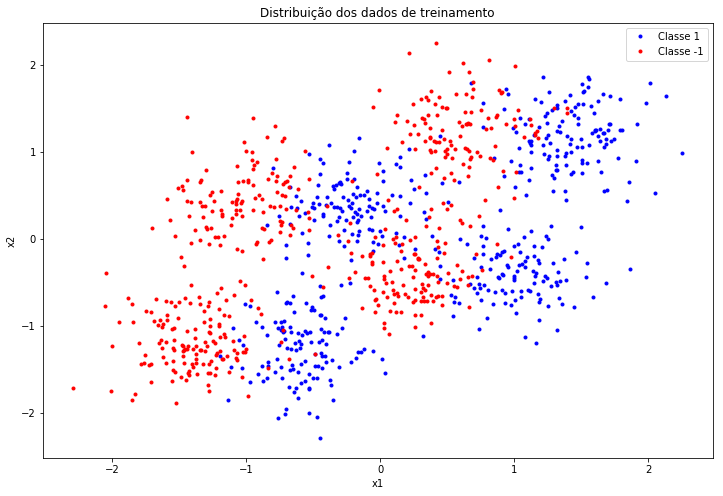

In [6]:
tx = train['X']
ty = train['y']
plt.plot(tx[ty==1, 0], tx[ty==1, 1], 'b.', label='Classe 1')
plt.plot(tx[ty==0, 0], tx[ty==0, 1], 'r.', label='Classe -1')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribuição dos dados de treinamento')

A distribuição dos dados de treinamento sugere que, para que um classificador obtenha boa taxa de acerto, é necessário que a fronteira de decisão seja não-linear. Isto é, separar as classes através de uma reta não atingirá boas taxas de acerto.

## (a) Definição do modelo de rede neural

Neste exercício, utilizará-se uma rede neural do tipo Multilayer Perceptron, com a restrição de utilizar-mos apenas uma camada intermediária. A camada de entrada possui dois neurônios e a camada de saída, apenas um. As decisões de projeto foram:

- **Função de ativação:** logística. A função logística foi escolhida como ativação como forma de adicionar uma não-linearidade ao problema. Como observado anteriormente, uma fronteira de decisão que se aproxime da solução MAP deve ser bastante complexa e não linear, o que favorece a escolha.
- **Função custo e função de ativação de saída:** cross-entropy e função logística. Para problemas de classificação (binária e multiclasse), a função de ativação de saída padrão do `scikit-learn` é logística/softmax. Ao utilizar essa função, é comum utilizar cross-entropy devido a seu comportamento convexo quando combinado à função logística.
- **Número de neurônios:** 7. Escolhido empiricamente, observou-se que 8 neurônios na camada intermediária são suficientes para descrever a complexidade do problema em questão.
- **Algoritmo de otimização:** Stochastic Gradient Descent (SGD). Empregou-se o SGD com um batch de tamanho `50` e passo `0,05`. Além disso, foi utilizado um termo de momento com coeficiente igual a `0,98`. Essa combinação de tamanho de batch, passo e coeficiente de momento foi suficiente para que *(1)* a otimização da função custo não terminasse em mínimos locais, conforme será observado na progressão da função custo em função do número de épocas, e *(2)* a função custo convergisse dentro do número de épocas pre-estabelecido. O conjunto de treino é embaralhado entre as épocas.
- **Regularização:** early stopping e regularização L2. Empregou-se a técnica de early stopping sobre o conjunto de validação, i.e., o número de épocas utilizado foi `1000`, maior que o necessário para a convergência, e a época com menor valor de função custo (sobre os dados de validação) foi escolhida como "vencedora". Além disso, o processo foi repetido para diferentes valores de regularização L2, e escolheu-se a regularização que proporcionasse o modelo com o menor valor de cross-entropy possível sobre os dados de validação.
- **Inicialização dos pesos:** distribuição aleatória uniforme. Utilizou-se a inicialização padrão do {{scikit-learn}}, que é semelhante ao explorado em aula. Para o caso de função de ativação logística, os pesos são inicializados amostrando-se a distribuição $U\left(-\sqrt{\frac{2}{(n+m)}}, \sqrt{\frac{2}{(n+m)}}\right)$. Código fonte: https://github.com/scikit-learn/scikit-learn/blob/7813f7efb/sklearn/neural_network/multilayer_perceptron.py#L295


In [7]:
def fit_mlp_regularized(train, val, n_neurons, regularization, verbose=False):
    mlp = MLPClassifier(hidden_layer_sizes=(n_neurons, ), activation='logistic', solver='sgd', alpha=regularization,
                  batch_size=50, learning_rate='constant', learning_rate_init=0.05, max_iter=1,
                  shuffle=True, verbose=verbose, warm_start=True, momentum=0.98, nesterovs_momentum=False,
                  early_stopping=False, validation_fraction=0, tol=1)

    train_log_loss = []
    val_log_loss = []
    best = {}
    best['val_ll'] = np.inf
    
    N_EPOCHS = 1000
    epoch = 0
    for epoch in range(N_EPOCHS):
        if verbose: print('Época #', epoch+1)
        mlp.fit(train['X'], train['y'])

        # loss for training data
        train_log_loss.append(log_loss(train['y'], mlp.predict_proba(train['X'])))
        val_log_loss.append(log_loss(val['y'], mlp.predict_proba(val['X'])))

        if verbose: print( 'Treino:    log_loss = ', log_loss(train['y'], mlp.predict_proba(train['X'])) )
        if verbose: print( 'Validação: log_loss = ',  log_loss(val['y'], mlp.predict_proba(val['X'])) )

        if verbose: print( 'Treino:    accuracy = ', accuracy(train['y'], mlp.predict(train['X'])) )
        if verbose: print( 'Validação: accuracy = ', accuracy(val['y'], mlp.predict(val['X'])) )

        # save best model based on logloss for validation data
        if best['val_ll'] > val_log_loss[-1]:
            best['val_ll']     = val_log_loss[-1]
            best['coefs']      = mlp.coefs_.copy()
            best['intercepts'] = mlp.intercepts_.copy()
            best['epoch']      = epoch + 1
    
    mlp.coefs_      = best['coefs']
    mlp.intercepts_ = best['intercepts']

    return mlp, train_log_loss, val_log_loss, best


In [8]:
def cross_validation(train, val, n_neurons):
    best_logloss = np.inf
    for reg in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0]:
        m, t, v, a = fit_mlp_regularized(train, val, n_neurons, reg)

        if best_logloss > a['val_ll']:
            mlp, train_log_loss, val_log_loss, att = m, t, v, a
            best_reg = reg

    return mlp, train_log_loss, val_log_loss, att, reg


In [9]:
def plot_mesh(model, nneurons, data=None, stepsize=0.02):
    h = stepsize  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = -2.5, 2.5
    y_min, y_max = -2.5, 2.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Região de decisão - modelo com %d neurônios' % nneurons)
    if data is not None:
        tx = data['X']
        ty = data['y']
        plt.plot(tx[ty==1, 0], tx[ty==1, 1], 'b.', label='Classe 1')
        plt.plot(tx[ty==0, 0], tx[ty==0, 1], 'r.', label='Classe -1')
        plt.legend()
        

In [10]:
def plot_result(d_tst, d_tst_pred):
    d_tst_y = d_tst['y']
    
    tp = (d_tst_y == 1) & (d_tst_pred == 1)
    tn = (d_tst_y == 0) & (d_tst_pred == 0)
    fp = (d_tst_y == 0) & (d_tst_pred == 1)
    fn = (d_tst_y == 1) & (d_tst_pred == 0)

    plt.scatter(x = d_tst['X'][tp, 0], y = d_tst['X'][tp, 1],  c='blue', marker='o',alpha=0.2,
                edgecolors='none', s=30, label='True Positive');
    plt.scatter(x = d_tst['X'][tn, 0], y = d_tst['X'][tn, 1],  c='red', marker='o',alpha=0.2,
                edgecolors='none', s=30, label='True Negative');
    plt.scatter(x = d_tst['X'][fp, 0], y = d_tst['X'][fp, 1],  c='red', marker='x',alpha=0.8,
                edgecolors='none', s=30, label='False Positive');
    plt.scatter(x = d_tst['X'][fn, 0], y = d_tst['X'][fn, 1],  c='blue', marker='x',alpha=0.8,
                edgecolors='none', s=30, label='False Negative');
    plt.xlim([-2.5,2.5]);
    plt.ylim([-2.5,2.5]);
    
    plt.legend()

In [11]:
def accuracy(y_real, y_pred):
    TP = ((y_real == 1) & (y_pred == 1)).sum()
    TN = ((y_real == 0) & (y_pred == 0)).sum()
    
    r = (TP + TN) / y_real.shape[0]
    return r


In [12]:
def cost_func_evolution(train_log_loss, val_log_loss, nneurons):
    plt.plot(train_log_loss, label='Dados de treino')
    plt.plot(val_log_loss, label='Dados de validação')
    plt.xscale('log')
    plt.xlabel('Número de épocas')
    plt.ylabel('Função custo (log-loss)')
    plt.legend()
    plt.title('Evolução da função custo - modelo com %d neurônios' % nneurons)


In [13]:
nneurons = 7
mlp, train_log_loss, val_log_loss, att, reg = cross_validation(train, val, nneurons)

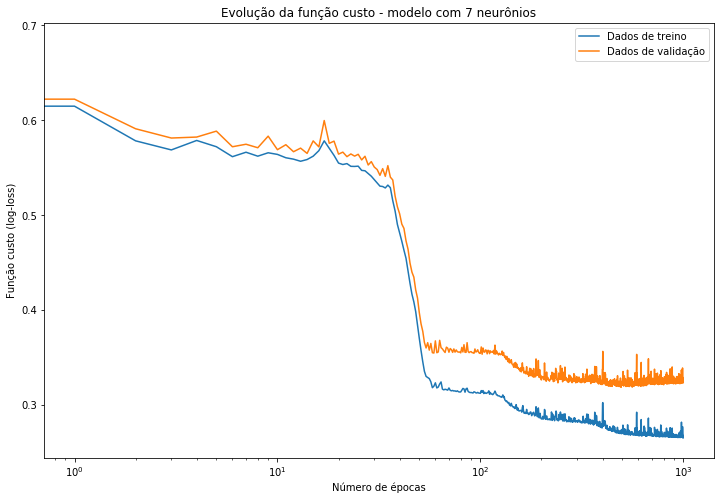

In [14]:
cost_func_evolution(train_log_loss, val_log_loss, nneurons)

In [15]:
print("Regularização L2:       %d" % reg)
print("Log-loss ótimo:         %f" % att['val_ll'])
print("Número de épocas ótimo: %d" % att['epoch'])

Regularização L2:       0
Log-loss ótimo:         0.318331
Número de épocas ótimo: 494


Observa-se na figura anterior a evolução da função custo (log-loss) em função do número de épocas. Utilizou-se escala logarítmica no eixo x. O custo para os dados de treino manteve-se abaixo do custo para os dados de validação, o que é esperado. O menor valor de custo para dados de validação ocorreu na época `494`, com valor de `0.318331`. É interessante notar que a regularização L2 ótima foi `0`, o que indica que a técnica de early stopping foi suficiente para obter modelos com boa generalização, que não sofram de overfitting.

A evolução da função custo é bastante ruidosa, principalmente nas primeiras épocas. Tal comportamento pode ser atribuido ao emprego do algoritmo SGD. Entretando, tal comportamento não impediu a convergência do algoritmo. 

## (b) Regiões de decisão

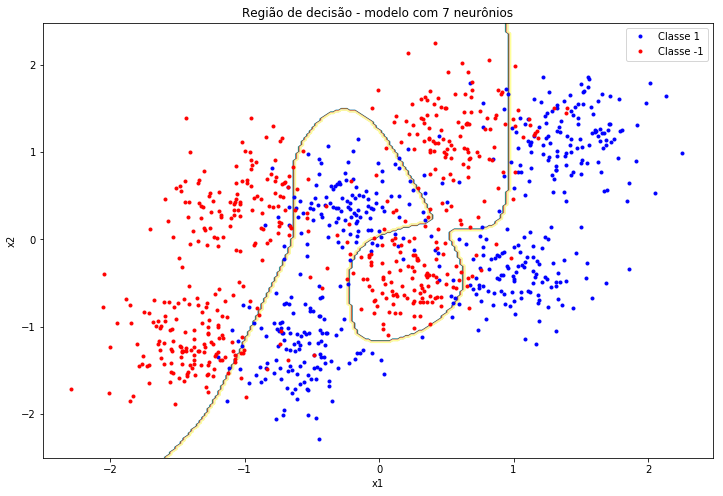

In [16]:
plot_mesh(mlp, nneurons, train)

Acima temos a fronteira de decisão definida pelo modelo. Junto da fronteira de decisão, apresentamos também os pontos de treinamento. Observa-se que a rede foi capaz de se adequar às não-linearidades do problema, assemelhando-se ao formato da região de decisão do classificador ótimo MAP, fornecido junto ao enunciado das questões.

## (c) Aplicando o modelo aos dados de treinamento

In [17]:
y_pred = mlp.predict(test['X'])
print("Acurácia sobre dados de treinamento:           %f" % accuracy(test['y'], y_pred))
print("Percentual de erro sobre dados de treinamento: {}%".format(100*(1 - accuracy(test['y'], y_pred))))

Acurácia sobre dados de treinamento:           0.886000
Percentual de erro sobre dados de treinamento: 11.399999999999999%


Text(0.5, 1.0, 'Região de decisão & saída gerada para os dados de teste')

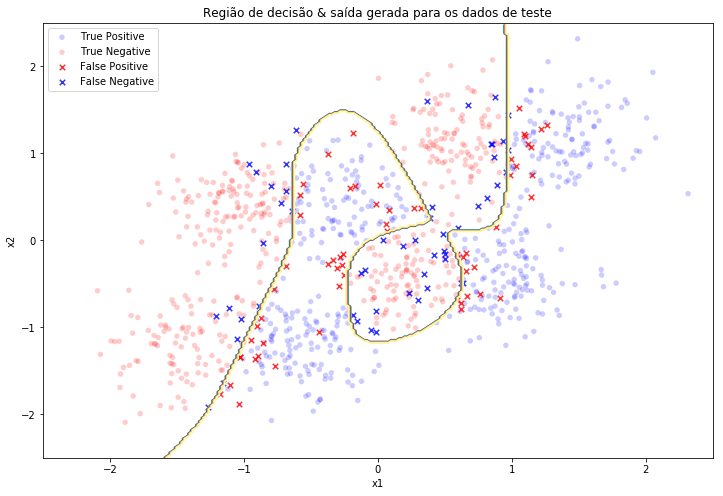

In [18]:
plot_result(test, y_pred)
plot_mesh(mlp, nneurons)
plt.title('Região de decisão & saída gerada para os dados de teste')

A taxa de erro sobre os dados de teste foi de `11,4%`. Observa-se que boa parte dos pontos onde o classificador erra estão sobrepostos a pontos da classe oposta. Dificilmente um modelo sem memória seria capaz de atingir taxa de erro expressivamente superior ao obtido.

## (d) Modificando o número de neurônios na camada intermediária

### Primeiro teste: aumentar o número de neurônios

O primeiro teste feito foi o de aumentar expressivamente o número de neurônios. Aumentamos o número para `100`.

In [19]:
nneurons = 100
mlp, train_log_loss, val_log_loss, att, reg = cross_validation(train, val, nneurons)

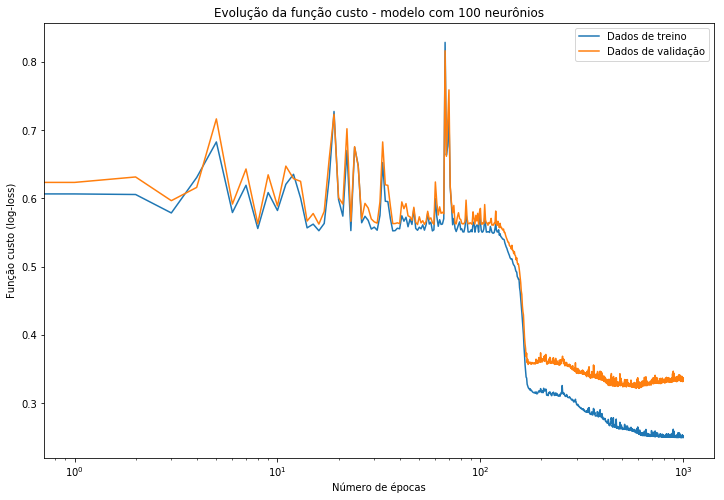

In [20]:
cost_func_evolution(train_log_loss, val_log_loss, nneurons)

In [21]:
print("Regularização L2:       %d" % reg)
print("Log-loss ótimo:         %f" % att['val_ll'])
print("Número de épocas ótimo: %d" % att['epoch'])

Regularização L2:       0
Log-loss ótimo:         0.321741
Número de épocas ótimo: 604


In [22]:
y_pred = mlp.predict(test['X'])
print("Acurácia sobre dados de treinamento:           %f" % accuracy(test['y'], y_pred))
print("Percentual de erro sobre dados de treinamento: {}%".format(100*(1 - accuracy(test['y'], y_pred))))

Acurácia sobre dados de treinamento:           0.884000
Percentual de erro sobre dados de treinamento: 11.6%


Text(0.5, 1.0, 'Região de decisão & saída gerada para os dados de teste')

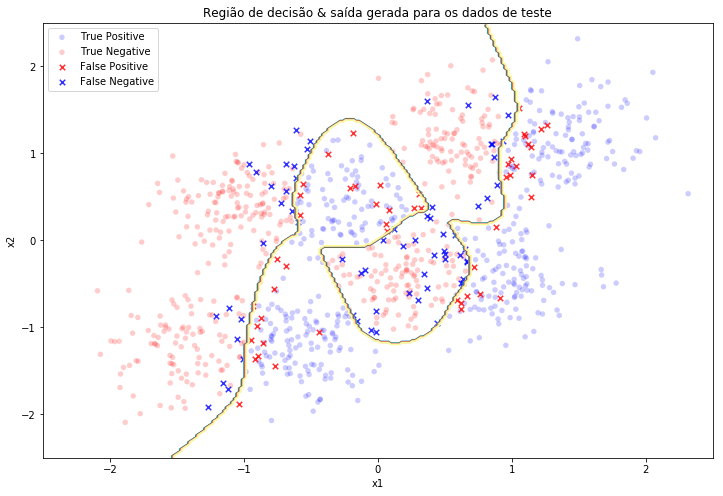

In [23]:
plot_result(test, y_pred)
plot_mesh(mlp, nneurons)
plt.title('Região de decisão & saída gerada para os dados de teste')

Observa-se que o número de épocas obtido pelo early stopping aumentou, o que indica um custo computacional maior para o treinamento da rede. O número poderia ser reduzido ao modificar-se o algoritmo de otimização em uso, mas não foi explorado neste exercício. A região de decisão foi bastante semelhante à rede anterior. Acredita-se que a regularização utilizada permitiu que mesmo com um número de neurônios maior o modelo não sofreu de overfitting.

De forma semelhante, a regularização L2 não foi acionada, o que indica que early stopping foi suficiente para gerar modelos com baixa variância. Caso a regularização não fosse efetiva, esperava-se que o modelo com mais neurônios sofresse de overffiting, o que não foi o observado.

A taxa de erro foi de `11.6`, o que é semelhante ao modelo anterior.

### Segundo teste: diminuir o número de neurônios

In [24]:
nneurons = 3
mlp, train_log_loss, val_log_loss, att, reg = cross_validation(train, val, nneurons)

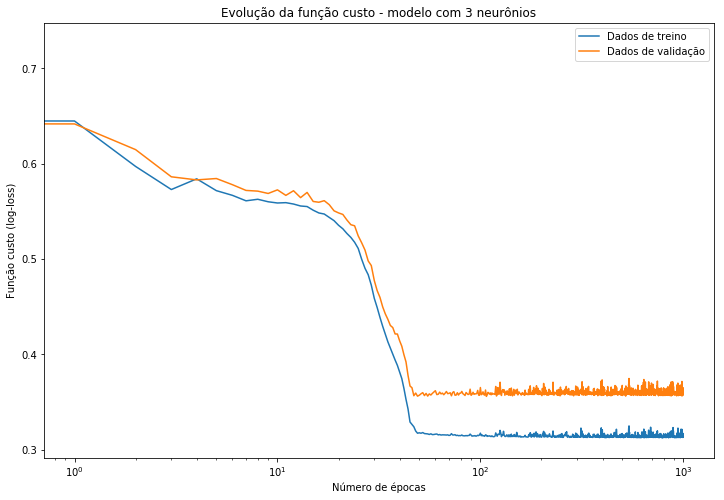

In [25]:
cost_func_evolution(train_log_loss, val_log_loss, nneurons)

In [26]:
print("Regularização L2:       %d" % reg)
print("Log-loss ótimo:         %f" % att['val_ll'])
print("Número de épocas ótimo: %d" % att['epoch'])

Regularização L2:       0
Log-loss ótimo:         0.355735
Número de épocas ótimo: 108


In [27]:
y_pred = mlp.predict(test['X'])
print("Acurácia sobre dados de treinamento:           %f" % accuracy(test['y'], y_pred))
print("Percentual de erro sobre dados de treinamento: {}%".format(100*(1 - accuracy(test['y'], y_pred))))

Acurácia sobre dados de treinamento:           0.853000
Percentual de erro sobre dados de treinamento: 14.700000000000003%


Text(0.5, 1.0, 'Região de decisão & saída gerada para os dados de teste')

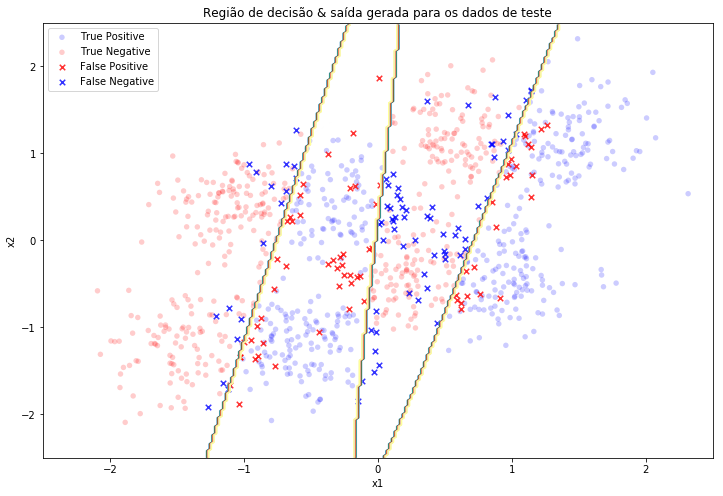

In [28]:
plot_result(test, y_pred)
plot_mesh(mlp, nneurons)
plt.title('Região de decisão & saída gerada para os dados de teste')

Observa-se que a região de decisão para uma rede com `3` neurônios é mais simples, isto é, ela não possúi a mesma flexibilidade que as outras redes. A fronteira de decisão se assemelha a combinação de algumas retas.

O número de épocas necessário para a convergência é o menor até então, necessitando de apenas `108` para a convergência para satisfazer o early stopping.

Houve um aumento na taxa de erro, que passa a ser de `14.7`. Conclui-se que o modelo treinado com apenas `3` neurônios sofre de underfitting, pois este não é flexível o bastante para o conjunto de dados do problema.